In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn import compose, pipeline, set_config, metrics, svm, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingClassifier
import sklearn.metrics as metrics
import sklearn.impute as impute
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
import re
import nltk

**Part A**

**1) Perform Exploratory Data Analysis (EDA) and discuss the data and what you observe
prior to beginning modeling and how impact how to proceed [10 pts]**

In [2]:
sns.set(rc = {'figure.figsize':(15,8)})

In [3]:
set_config(display="diagram")

In [4]:
diabetes_data = pd.read_csv("8k_diabetes.csv", delimiter=',')

In [5]:
np_readmitted = diabetes_data.loc[:,"readmitted"].to_numpy()
ratio_readmitted = np.sum(np.where(np_readmitted, 1, 0))/len(np_readmitted)

In [6]:
ratio_readmitted

0.39725

The `ratio_readmitted` provides an important baseline which we will use to compare the performance of different models.

In [7]:
diabetes_data.loc[:,"readmitted"] = diabetes_data.loc[:,"readmitted"].astype(int)

<AxesSubplot:>

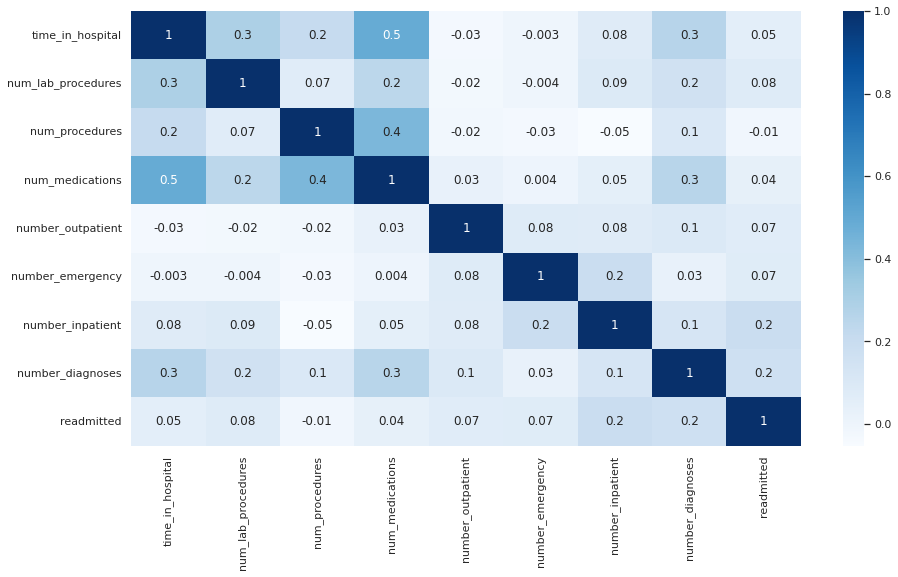

In [8]:
sns.heatmap(diabetes_data.corr(), annot=True, cmap="Blues", fmt='.1g')

The first thing I look for here is features that are highly correlated with each other, which may result in an overfitted model under certain architectures. So I use Seaborn to create the heatmap you see above to measure those correlations among the numerical scalar valued features.

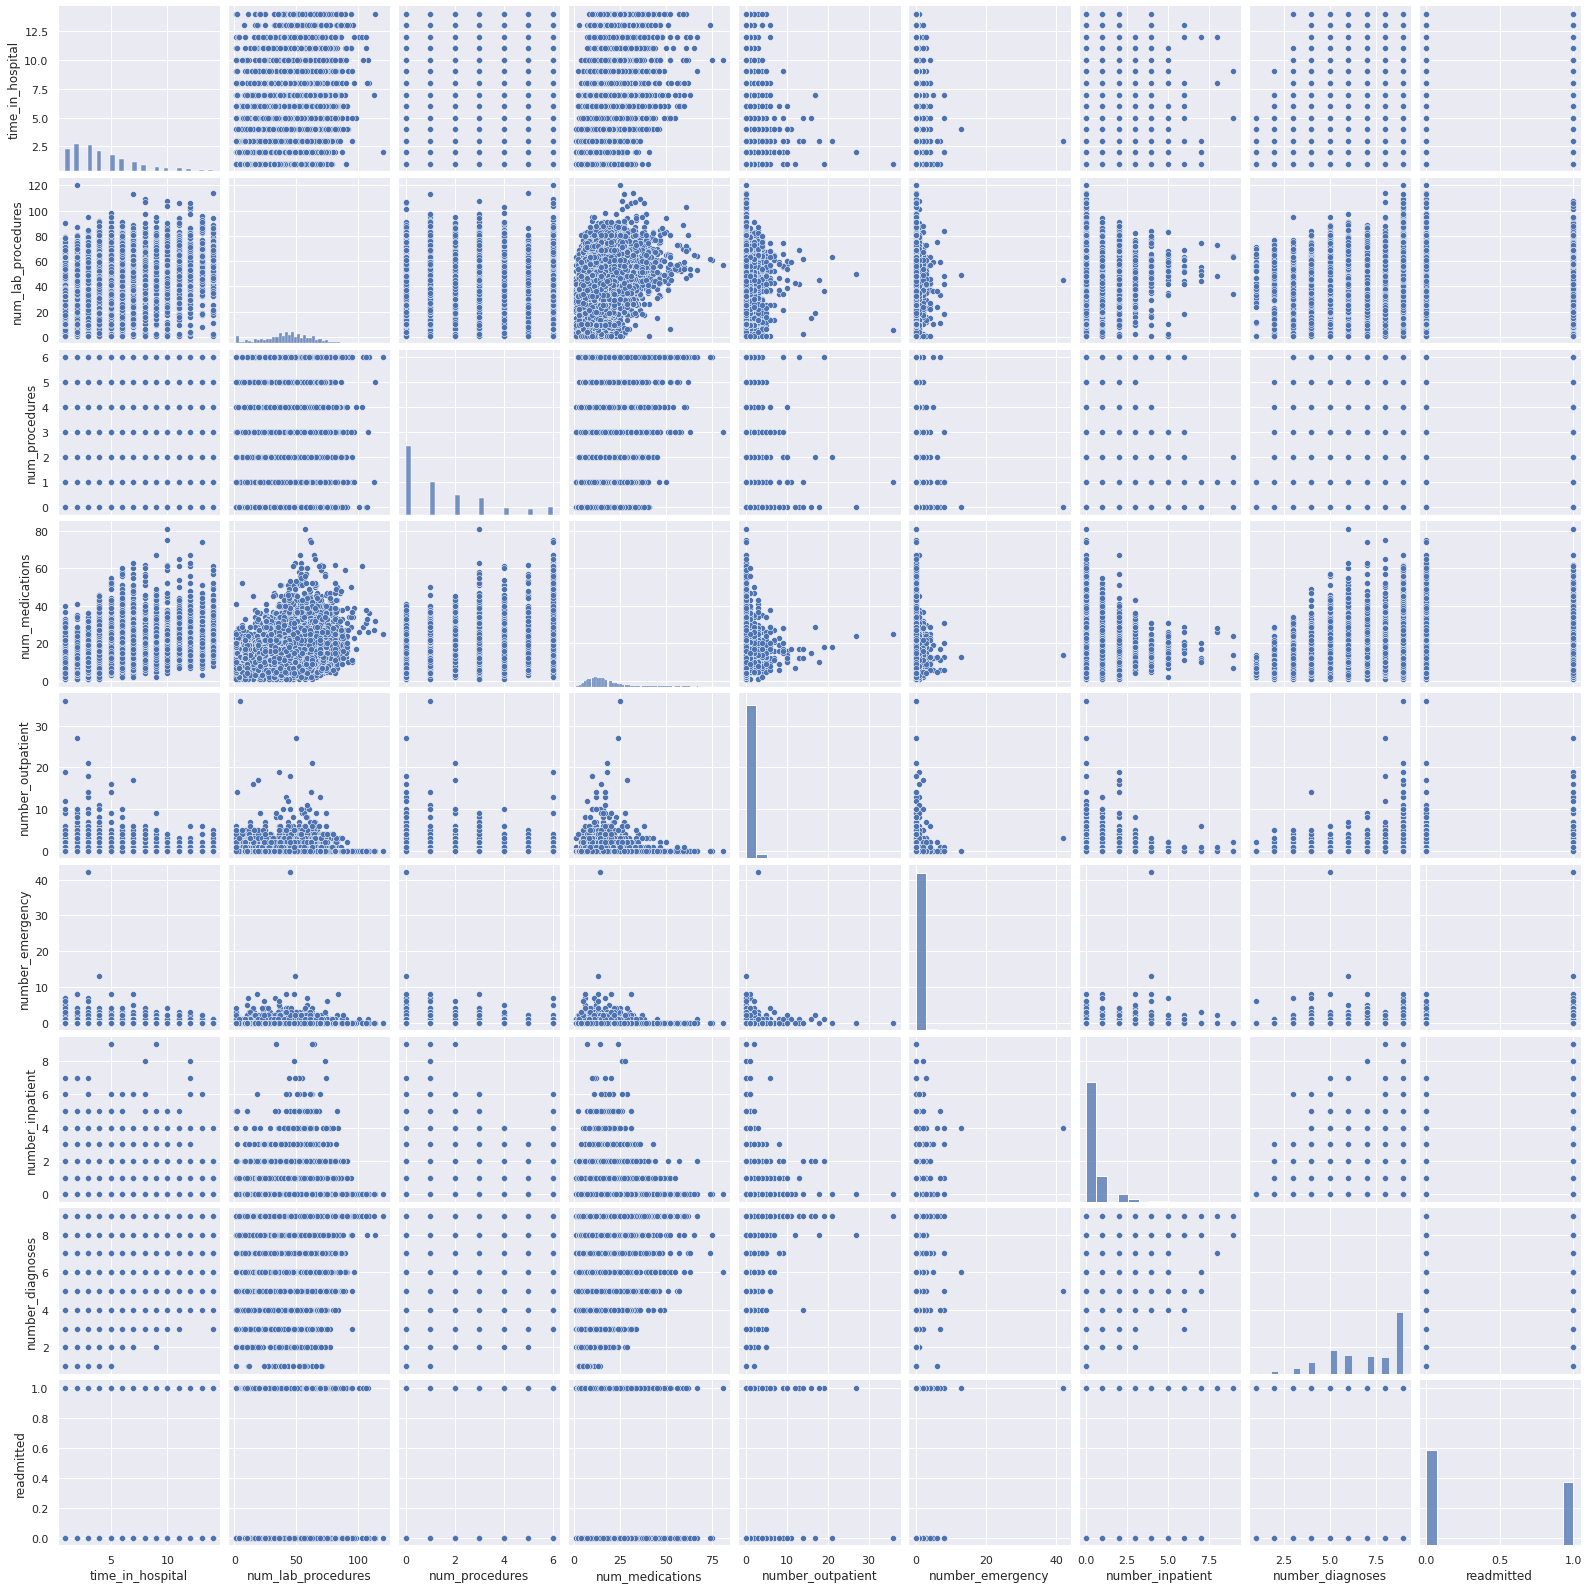

In [9]:
sns.pairplot(diabetes_data)

Next I recreate the previous heatmap in the form of a scatterplot matrix. This proves difficult to interpret, especially for our binary valued `readmitted` feature. Ultimatley, I decide not to drop any features.

In [10]:
diabetes_data.isna().sum()

race                          0
gender                        0
age                           0
weight                        0
admission_type_id           576
discharge_disposition_id    373
admission_source_id         750
time_in_hospital              0
payer_code                    0
medical_specialty             0
num_lab_procedures            0
num_procedures                0
num_medications               0
number_outpatient             0
number_emergency              0
number_inpatient              0
diag_1                        0
diag_2                        0
diag_3                        0
number_diagnoses              0
max_glu_serum                 0
A1Cresult                     0
metformin                     0
repaglinide                   0
nateglinide                   0
chlorpropamide                0
glimepiride                   0
acetohexamide                 0
glipizide                     0
glyburide                     0
tolbutamide                   0
pioglita

Next, I look for NaN values in each column that will have to be dealt with before they can be used by the data pipeline. It looks like the text columns `diag_1_desc`, `diag_2_desc`, `diag_3_desc`, `admission_type_id`, `discharge_disposition_id`, and `admission_source_id` have NaN valued cells. My first approach will be a naive one wherein I merely replace each NaN cell with an empty string, to which Tf-Idf should be fairly robust.

**2. Pre-process categorical data for use in the model and justify pre-processing
method. Note this may be different for each algorithm you try. [10 pts]**

In [11]:
categorical_data = [
    "race",
    "gender",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "insulin",
    "diabetesMed",
    "change",
    "payer_code",
    "A1Cresult",
    "metformin",
    "repaglinide",
    "nateglinide",
    "chlorpropamide",
    "glimepiride",
    "glipizide",
    "glyburide",
    "tolbutamide",
    "pioglitazone",
    "rosiglitazone",
    "acarbose",
    "miglitol",
    "tolazamide",
    "glyburide.metformin",
    "glipizide.metformin",
    "citoglipton",
    "medical_specialty",
    "max_glu_serum",
    "metformin.rosiglitazone",
    "metformin.pioglitazone",
    "acetohexamide",
    "examide",
    "glimepiride.pioglitazone",
]

ordinal_data = [
    "age",
    "weight"
]

In [12]:
ordinal_categories = [
    ["[0-10)", "[10-20)", "[20-30)", "[30-40)", "[40-50)", "[50-60)", "[60-70)", "[70-80)", "[80-90)"],
    ["[0-25)", "[25-50)", "[50-75)", "[75-100)", "[100-125)", "[125-150)"]
]

In [13]:
cat_trans = compose.make_column_transformer(
    (make_pipeline(
        impute.SimpleImputer(
            strategy="constant",
            fill_value="missing"
        ),
        preprocessing.OneHotEncoder(
            sparse=False,
            handle_unknown="ignore"
        )
    ), categorical_data),
    (make_pipeline(
        impute.SimpleImputer(
            strategy="constant",
            fill_value="missing"
        ),
        preprocessing.OrdinalEncoder(
            categories = ordinal_categories,
            handle_unknown="use_encoded_value",
            unknown_value=-1
        )
    ), ordinal_data),
)

Here I use a simple imputer on the categorical and ordinal features. Then I use OneHotEncoder for the categorical feartures and OrdinalEncoder for the ordinal features. All of this is encapsulated in a column transformer containing a pipeline for each data type.

**3. Pre-process numerical data appropriately including handling missing data and
justify methods used. Note this may be different for each algorithm you try. [10 pts]**

In [15]:
scalar_data = [
    "num_medications",
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses",
]

In [16]:
scalar_trans = compose.make_column_transformer(
    (preprocessing.StandardScaler(), scalar_data),
)

Here I create a ColumnTransfomer that applies StandardScaler to each of the numeric features, as many of them are neither normally distributed not centered around zero.

**4. Implement a model to make predictions using text data using tf-idf [20 pts]**

In [17]:
def preprocess_text(text):
    try:
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower().split()
        text = [word for word in text if not word in set(nltk.corpus.stopwords.words('english'))]
        text = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in text if len(word) > 1]
        return ' '.join(text)
    except TypeError:
        return ''

def preprocess_series(series):
    return pd.Series([preprocess_text(text) for text in series])

def preprocess_dataframe(dframe):
    return pd.DataFrame({column_name : preprocess_series(dframe[column_name]) for column_name in dframe})

In [18]:
text_data = [
    "diag_1_desc",
    "diag_2_desc",
    "diag_3_desc"
]

In [19]:
text_trans = compose.make_column_transformer(
    (TfidfVectorizer(ngram_range=(1,2)), "diag_1_desc"),
    (TfidfVectorizer(ngram_range=(1,2)), "diag_2_desc"),
    (TfidfVectorizer(ngram_range=(1,2)), "diag_3_desc"),
)

In [20]:
logreg = LogisticRegression(
    solver = "saga",
    penalty="elasticnet",
    l1_ratio=0.5,
    max_iter=1000
)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    preprocess_dataframe(diabetes_data[text_data]),
    diabetes_data["readmitted"]
)

In [22]:
pipe = pipeline.make_pipeline(text_trans, logreg)

In [23]:
pipe.fit(x_train, y_train);

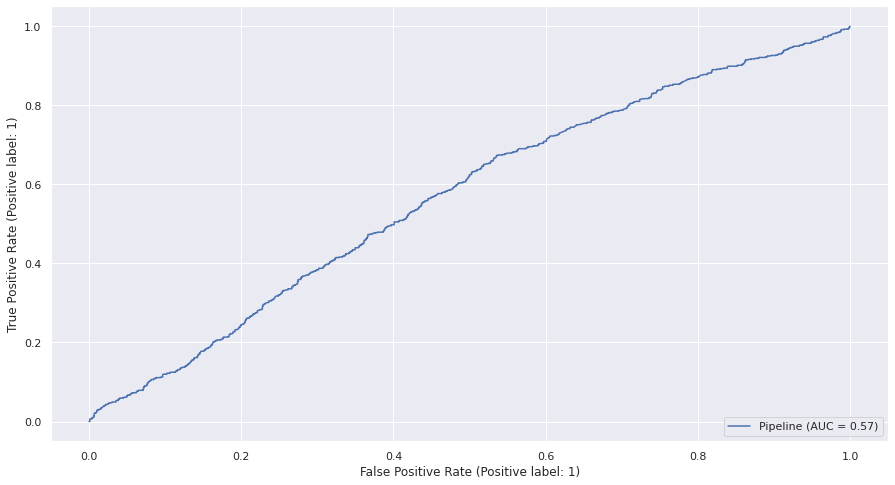

In [24]:
RocCurveDisplay.from_estimator(pipe, x_test, y_test)

In [25]:
cross_val_score(
    pipe,
    preprocess_dataframe(diabetes_data[text_data]),
    diabetes_data["readmitted"],
    cv=3, 
    scoring="roc_auc"
).mean()

0.574290145977482

Here I use TfidfVectorizer to compare records based on their text fields and evaluate a naive model using Tfidf with LogisticRegression.

**5. Use model stacking to incorporate tf-idf predictions for all 3 text fields (so 3 models
unless you elect to concatenate the text fields into 1 - need to justify if so) in
downstream algorithm the uses non-text features [20 pts]**

In [26]:
text_pipe = make_pipeline(text_trans, logreg)
scalar_pipe = make_pipeline(scalar_trans, logreg)
cat_pipe = make_pipeline(cat_trans, logreg)

In [27]:
estimators = [
    ("cat", cat_pipe),
    ("text", text_pipe),
    ("scalar", scalar_pipe)
]

In [28]:
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=logreg
)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(
    pd.concat([
        preprocess_dataframe(diabetes_data[text_data]),
        diabetes_data[categorical_data + ordinal_data + scalar_data]
    ], axis=1),
    diabetes_data["readmitted"]
)

In [31]:
stack_clf.fit(x_train, y_train)

StackingClassifier(estimators=[('cat',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('pipeline-1',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('onehotencoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['race',
                                                                                   'gender',
                                                                                   'admission_type_id',
                                                                                   'discharge_disposition_id',
                                                                                   'ad...
                                                                                  ['num_medications',
                                                                                   'time_in_hospital',
                                                                                   'num_lab_procedures',
                                                                                   'num_procedures',
                                                                                   'number_outpatient',
                                                                                   'number_emergency',
                                                                                   'number_inpatient',
                                                                                   'number_diagnoses'])])),
                                                ('logisticregression',
                                                 LogisticRegression(l1_ratio=0.5,
                                                                    max_iter=1000,
                                                                    penalty='elasticnet',
                                                                    solver='saga'))]))],
                   final_estimator=LogisticRegression(l1_ratio=0.5,
                                                      max_iter=1000,
                                                      penalty='elasticnet',
                                                      solver='saga'))

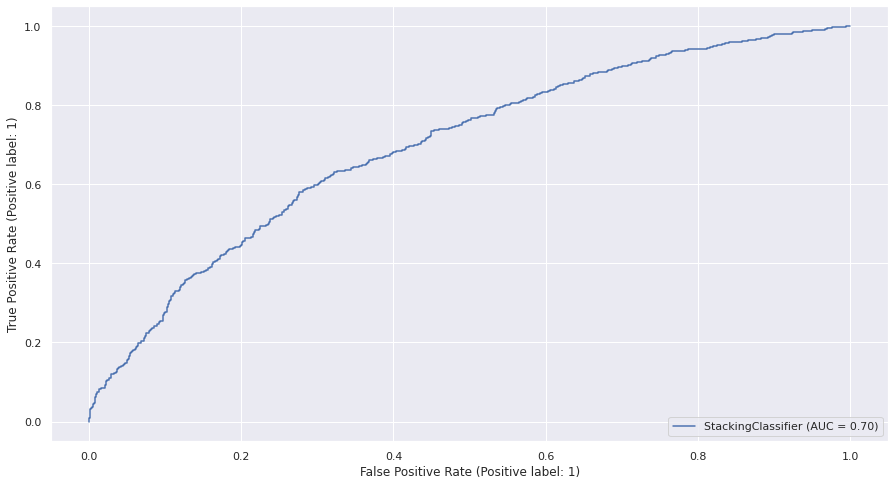

In [32]:
RocCurveDisplay.from_estimator(stack_clf, x_test, y_test)

In [33]:
cross_val_score(
    stack_clf,
    pd.concat([
        preprocess_dataframe(diabetes_data[text_data]),
        diabetes_data[categorical_data + ordinal_data + scalar_data]
    ], axis=1),
    diabetes_data["readmitted"],
    cv=3,
    scoring="roc_auc"
).mean()

0.696438385790057

**6. Perform experimentation for multiple modeling algorithms and justify why you
selected the experiments you chose [20 pts]**

In this section, I perform several experiemnts using three classification algorithms. First I take a naive approach and simply use the default version of each classifier. Then to improve performance, I perform a random hyperparameter sweep on each StackingClassifier.

In [34]:
svc = svm.SVC()

logreg = LogisticRegression(
    solver = "saga",
    penalty="elasticnet",
    l1_ratio=0.5,
    max_iter=1000
)

random_forest = RandomForestClassifier()

First I will experiment with a default support vector machine to try and boost the AUC score.

In [35]:
text_pipe = make_pipeline(text_trans, svc)
scalar_pipe = make_pipeline(scalar_trans, svc)
cat_pipe = make_pipeline(cat_trans, svc)

In [36]:
estimators = [
    ("cat", cat_pipe),
    ("text", text_pipe),
    ("scalar", scalar_pipe)
]

In [37]:
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=svc
)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(
    pd.concat([
        preprocess_dataframe(diabetes_data[text_data]),
        diabetes_data[categorical_data + ordinal_data + scalar_data]
    ], axis=1),
    diabetes_data["readmitted"]
)

In [40]:
stack_clf.fit(x_train, y_train)

StackingClassifier(estimators=[('cat',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('pipeline-1',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('onehotencoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['race',
                                                                                   'gender',
                                                                                   'admission_type_id',
                                                                                   'discharge_disposition_id',
                                                                                   'ad...
                                                                                                               2)),
                                                                                  'diag_3_desc')])),
                                                ('svc', SVC())])),
                               ('scalar',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('standardscaler',
                                                                                  StandardScaler(),
                                                                                  ['num_medications',
                                                                                   'time_in_hospital',
                                                                                   'num_lab_procedures',
                                                                                   'num_procedures',
                                                                                   'number_outpatient',
                                                                                   'number_emergency',
                                                                                   'number_inpatient',
                                                                                   'number_diagnoses'])])),
                                                ('svc', SVC())]))],
                   final_estimator=SVC())

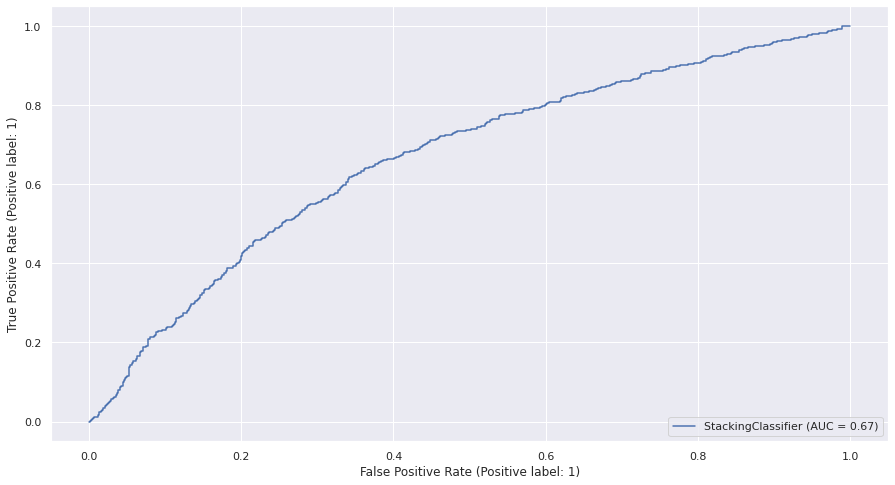

In [41]:
RocCurveDisplay.from_estimator(stack_clf, x_test, y_test)

In [42]:
cross_val_score(
    stack_clf,
    pd.concat([
        preprocess_dataframe(diabetes_data[text_data]),
        diabetes_data[categorical_data + ordinal_data + scalar_data]
    ], axis=1),
    diabetes_data["readmitted"],
    cv=3,
    scoring="roc_auc"
).mean()

0.667824504919842

Next I will rerun my cross validated pipeline using a RandomForest estimator instead.

In [43]:
text_pipe = make_pipeline(text_trans, random_forest)
scalar_pipe = make_pipeline(scalar_trans, random_forest)
cat_pipe = make_pipeline(cat_trans, random_forest)

In [44]:
estimators = [
    ("cat", cat_pipe),
    ("text", text_pipe),
    ("scalar", scalar_pipe)
]

In [45]:
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=random_forest
)

In [46]:
stack_clf.fit(x_train, y_train)

StackingClassifier(estimators=[('cat',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('pipeline-1',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('onehotencoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['race',
                                                                                   'gender',
                                                                                   'admission_type_id',
                                                                                   'discharge_disposition_id',
                                                                                   'ad...
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('standardscaler',
                                                                                  StandardScaler(),
                                                                                  ['num_medications',
                                                                                   'time_in_hospital',
                                                                                   'num_lab_procedures',
                                                                                   'num_procedures',
                                                                                   'number_outpatient',
                                                                                   'number_emergency',
                                                                                   'number_inpatient',
                                                                                   'number_diagnoses'])])),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier())]))],
                   final_estimator=RandomForestClassifier())

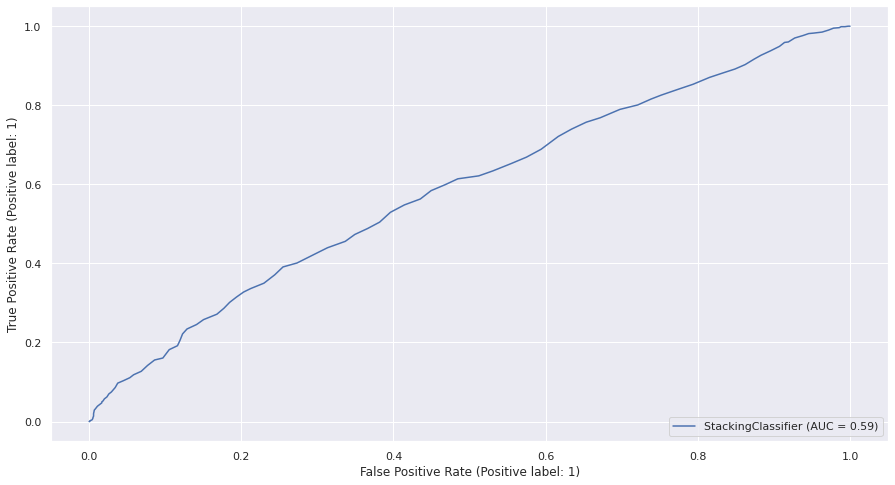

In [47]:
RocCurveDisplay.from_estimator(stack_clf, x_test, y_test)

In [48]:
cross_val_score(
    stack_clf,
    pd.concat([
        preprocess_dataframe(diabetes_data[text_data]),
        diabetes_data[categorical_data + ordinal_data + scalar_data]
    ], axis=1),
    diabetes_data["readmitted"],
    cv=3,
    scoring="roc_auc"
).mean()

0.6042159416403164

Since using the default versions of these classifiers did not improve performance, I will attempt a randomized hyperparameter grid search for each classifier algorithm. To streamline this process, I will create a simple class to setup the pipeline for each experiment.

In [49]:
class Pipeline:
    
    # Create StackingClassifier
    def __init__(self, estimator, params):
        self.estimator = estimator
        self.params = params
        
        self.text_pipe = make_pipeline(text_trans, estimator)
        self.scalar_pipe = make_pipeline(scalar_trans, estimator)
        self.cat_pipe = make_pipeline(cat_trans, estimator)
        
        self.estimators = [
            ("cat", self.cat_pipe),
            ("text", self.text_pipe),
            ("scalar", self.scalar_pipe)
        ]
        
        self.stack_clf = StackingClassifier(
            estimators = self.estimators,
            final_estimator = estimator
        )
        
    def fit(self, x_train, y_train):
        self.stack_clf.fit(x_train, y_train)
        
    def display_ROC(self, x_test, y_test):
        RocCurveDisplay.from_estimator(self.stack_clf, x_test, y_test)
        
    def cross_val_score(self, X, Y, cv=3, scoring="roc_auc"):
        return cross_val_score(self.stack_clf, X, Y, cv=cv, scoring=scoring).mean()
    
    def randomized_search_cv(self, scoring="roc_auc", n_iter=3):
        self.rand_search = RandomizedSearchCV(
            self.stack_clf,
            self.params,
            scoring=scoring,
            n_iter=n_iter
        )
        return self.rand_search
    
    def get_best_params(self):
        return self.rand_search.best_params_


In [50]:
log_reg = LogisticRegression(
    solver="saga",
    max_iter=1000,
)

In [51]:
hyperparameters = {
    "cat__logisticregression__C" : [0.01, 0.1, 1, 10, 100],
    "scalar__logisticregression__C" : [0.01, 0.1, 1, 10, 100],
    "text__logisticregression__C" : [0.01, 0.1, 1, 10, 100],
}

In [52]:
log_pipe = Pipeline(log_reg, hyperparameters)

In [53]:
log_pipe.fit(x_train,y_train)

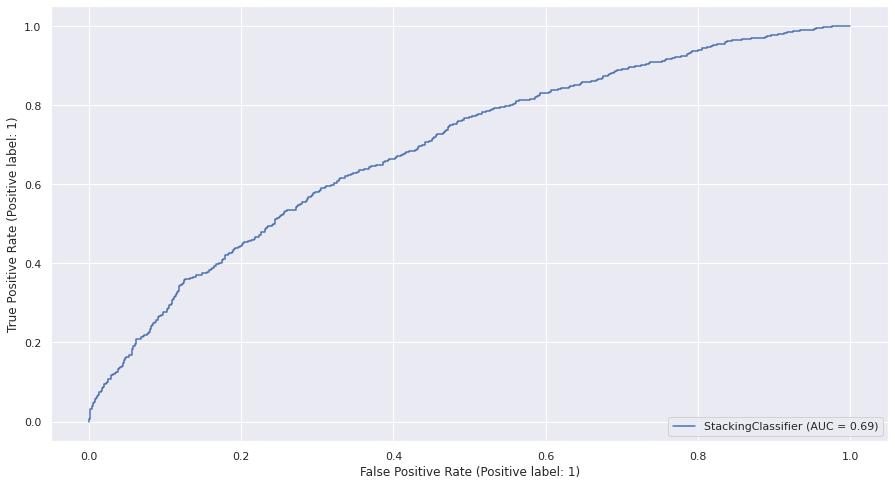

In [54]:
log_pipe.display_ROC(x_test, y_test)

In [55]:
log_pipe.cross_val_score(
    pd.concat([
        preprocess_dataframe(diabetes_data[text_data]),
        diabetes_data[categorical_data + ordinal_data + scalar_data]
    ], axis=1),
    diabetes_data["readmitted"]
)

0.6947485297989822

In [57]:
log_rand_clf = log_pipe.randomized_search_cv()

In [58]:
log_rand_clf.fit(
    pd.concat([
        preprocess_dataframe(diabetes_data[text_data]),
        diabetes_data[categorical_data + ordinal_data + scalar_data]
    ], axis=1),
    diabetes_data["readmitted"]
)

/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

RandomizedSearchCV(estimator=StackingClassifier(estimators=[('cat',
                                                             Pipeline(steps=[('columntransformer',
                                                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                                                SimpleImputer(fill_value='missing',
                                                                                                                                              strategy='constant')),
                                                                                                                               ('onehotencoder',
                                                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                                                              sparse=False))]),
                                                                                                               ['race',
                                                                                                                'gender',
                                                                                                                'admission_type_id',
                                                                                                                '...
                                                                                                                'number_diagnoses'])])),
                                                                             ('logisticregression',
                                                                              LogisticRegression(max_iter=1000,
                                                                                                 solver='saga'))]))],
                                                final_estimator=LogisticRegression(max_iter=1000,
                                                                                   solver='saga')),
                   n_iter=3,
                   param_distributions={'cat__logisticregression__C': [0.01,
                                                                       0.1, 1,
                                                                       10,
                                                                       100],
                                        'scalar__logisticregression__C': [0.01,
                                                                          0.1,
                                                                          1, 10,
                                                                          100],
                                        'text__logisticregression__C': [0.01,
                                                                        0.1, 1,
                                                                        10,
                                                                        100]},
                   scoring='roc_auc')

In [59]:
log_rand_clf.best_params_

{'text__logisticregression__C': 0.1,
 'scalar__logisticregression__C': 10,
 'cat__logisticregression__C': 10}

In [60]:
log_rand_clf.best_score_

0.6975600190782091

This was the best score achieved out of all models I attempted.

In [61]:
svc = svm.SVC()

In [62]:
hyperparameters = {
    "cat__svc__C" : [0.1, 1, 10],
    "scalar__svc__C" : [0.1, 1, 10],
    "text__svc__C" : [0.1, 1, 10],
    "cat__svc__kernel" : ['linear', 'poly', 'rbf'],
    "scalar__svc__kernel" : ['linear', 'poly', 'rbf'],
    "text__svc__kernel" : ['linear', 'poly', 'rbf']
}

In [63]:
svm_pipe = Pipeline(svc, hyperparameters)

In [64]:
svm_pipe.fit(x_train,y_train)

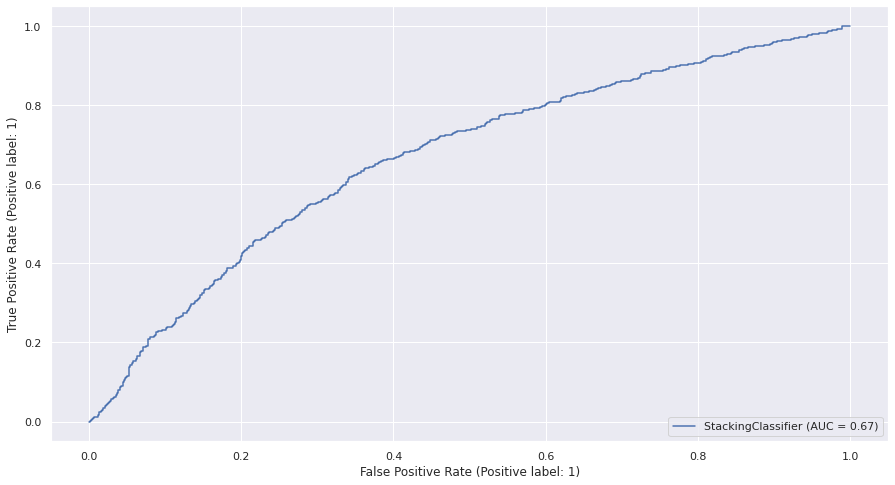

In [65]:
svm_pipe.display_ROC(x_test, y_test)

In [66]:
svm_pipe.cross_val_score(
    pd.concat([
        preprocess_dataframe(diabetes_data[text_data]),
        diabetes_data[categorical_data + ordinal_data + scalar_data]
    ], axis=1),
    diabetes_data["readmitted"]
)

0.667824504919842

In [67]:
svm_rand_clf = svm_pipe.randomized_search_cv()

In [68]:
svm_rand_clf.fit(
    pd.concat([
        preprocess_dataframe(diabetes_data[text_data]),
        diabetes_data[categorical_data + ordinal_data + scalar_data]
    ], axis=1),
    diabetes_data["readmitted"]
)

RandomizedSearchCV(estimator=StackingClassifier(estimators=[('cat',
                                                             Pipeline(steps=[('columntransformer',
                                                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                                                SimpleImputer(fill_value='missing',
                                                                                                                                              strategy='constant')),
                                                                                                                               ('onehotencoder',
                                                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                                                              sparse=False))]),
                                                                                                               ['race',
                                                                                                                'gender',
                                                                                                                'admission_type_id',
                                                                                                                '...
                                                                                                                'number_emergency',
                                                                                                                'number_inpatient',
                                                                                                                'number_diagnoses'])])),
                                                                             ('svc',
                                                                              SVC())]))],
                                                final_estimator=SVC()),
                   n_iter=3,
                   param_distributions={'cat__svc__C': [0.1, 1, 10],
                                        'cat__svc__kernel': ['linear', 'poly',
                                                             'rbf'],
                                        'scalar__svc__C': [0.1, 1, 10],
                                        'scalar__svc__kernel': ['linear',
                                                                'poly', 'rbf'],
                                        'text__svc__C': [0.1, 1, 10],
                                        'text__svc__kernel': ['linear', 'poly',
                                                              'rbf']},
                   scoring='roc_auc')

In [69]:
svm_rand_clf.best_params_

{'text__svc__kernel': 'poly',
 'text__svc__C': 1,
 'scalar__svc__kernel': 'linear',
 'scalar__svc__C': 10,
 'cat__svc__kernel': 'rbf',
 'cat__svc__C': 1}

In [70]:
svm_rand_clf.best_score_

0.6735263763536388

In [71]:
random_forest = RandomForestClassifier()

In [72]:
hyperparameters = {
    "cat__randomforestclassifier__n_estimators" : [10, 100, 500, 1000],
    "scalar__randomforestclassifier__n_estimators" : [10, 100, 500, 1000],
    "text__randomforestclassifier__n_estimators" : [10, 100, 500, 1000],
    "cat__randomforestclassifier__max_depth" : [5, 10, 15, 30, 60],
    "scalar__randomforestclassifier__max_depth" : [5, 10, 15, 30, 60],
    "text__randomforestclassifier__max_depth" : [5, 10, 15, 30, 60],
    "cat__randomforestclassifier__min_samples_split" : [2, 5, 10, 25, 100],
    "scalar__randomforestclassifier__min_samples_split" : [2, 5, 10, 25, 100],
    "text__randomforestclassifier__min_samples_split" : [2, 5, 10, 25, 100],
    
}

In [73]:
random_forest_pipe = Pipeline(random_forest, hyperparameters)

In [74]:
random_forest_pipe.fit(x_train,y_train)

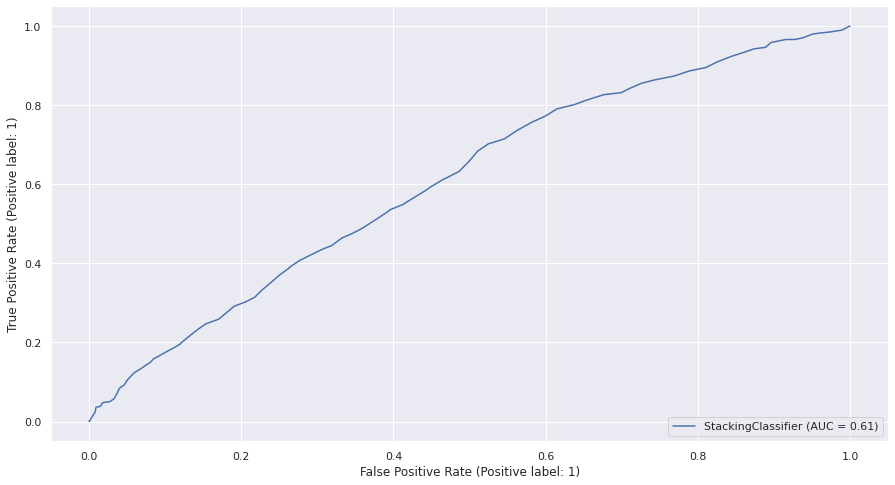

In [75]:
random_forest_pipe.display_ROC(x_test, y_test)

In [76]:
random_forest_rand_clf = random_forest_pipe.randomized_search_cv()

In [77]:
random_forest_rand_clf.fit(
    pd.concat([
        preprocess_dataframe(diabetes_data[text_data]),
        diabetes_data[categorical_data + ordinal_data + scalar_data]
    ], axis=1),
    diabetes_data["readmitted"]
)

RandomizedSearchCV(estimator=StackingClassifier(estimators=[('cat',
                                                             Pipeline(steps=[('columntransformer',
                                                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                                                SimpleImputer(fill_value='missing',
                                                                                                                                              strategy='constant')),
                                                                                                                               ('onehotencoder',
                                                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                                                              sparse=False))]),
                                                                                                               ['race',
                                                                                                                'gender',
                                                                                                                'admission_type_id',
                                                                                                                '...
                                                                                      10,
                                                                                      15,
                                                                                      30,
                                                                                      60],
                                        'scalar__randomforestclassifier__min_samples_split': [2,
                                                                                              5,
                                                                                              10,
                                                                                              25,
                                                                                              100],
                                        'scalar__randomforestclassifier__n_estimators': [10,
                                                                                         100,
                                                                                         500,
                                                                                         1000],
                                        'text__randomforestclassifier__max_depth': [5,
                                                                                    10,
                                                                                    15,
                                                                                    30,
                                                                                    60],
                                        'text__randomforestclassifier__min_samples_split': [2,
                                                                                            5,
                                                                                            10,
                                                                                            25,
                                                                                            100],
                                        'text__randomforestclassifier__n_estimators': [10,
                               

In [78]:
random_forest_rand_clf.best_params_

{'text__randomforestclassifier__n_estimators': 1000,
 'text__randomforestclassifier__min_samples_split': 2,
 'text__randomforestclassifier__max_depth': 5,
 'scalar__randomforestclassifier__n_estimators': 1000,
 'scalar__randomforestclassifier__min_samples_split': 25,
 'scalar__randomforestclassifier__max_depth': 30,
 'cat__randomforestclassifier__n_estimators': 100,
 'cat__randomforestclassifier__min_samples_split': 25,
 'cat__randomforestclassifier__max_depth': 60}

In [79]:
random_forest_rand_clf.best_score_

0.6469246545863059

7. Final model selection and discussion of your model choice and the model weaknesses
(generally, where model doesn’t perform well, etc.) [10 pts]

Ultimatley the model with the best AUC score was a stacked LogisticRegression classifier with the following hyperparmeters:

In [80]:
{'text__logisticregression__C': 0.1,
 'scalar__logisticregression__C': 1,
 'cat__logisticregression__C': 10}

{'text__logisticregression__C': 0.1,
 'scalar__logisticregression__C': 1,
 'cat__logisticregression__C': 10}

**Part B**

In [81]:
diabetes_scoring = pd.read_csv("2k_diabetes_scoring.csv", delimiter=',')

Here I will use the best parameters found by RandomizedSearchCV to predict the probabilities for the scoring dataset.

In [84]:
text_log = LogisticRegression(
    solver = "saga",
    penalty="elasticnet",
    l1_ratio=0.5,
    max_iter=1000,
    C=0.1
)

scalar_log = LogisticRegression(
    solver = "saga",
    penalty="elasticnet",
    l1_ratio=0.5,
    max_iter=1000,
    C=1
)

cat_log = LogisticRegression(
    solver = "saga",
    penalty="elasticnet",
    l1_ratio=0.5,
    max_iter=1000,
    C=10
)

In [85]:
final_text_pipe = make_pipeline(text_trans, text_log)
final_scalar_pipe = make_pipeline(scalar_trans, scalar_log)
final_cat_pipe = make_pipeline(cat_trans, cat_log)

In [86]:
final_estimators = [
    ("cat", final_cat_pipe),
    ("text", final_text_pipe),
    ("scalar", final_scalar_pipe)
]

In [87]:
final_stack_clf = StackingClassifier(
    estimators = final_estimators,
    final_estimator = log_reg
)

In [91]:
final_stack_clf

StackingClassifier(estimators=[('cat',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('pipeline-1',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('onehotencoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['race',
                                                                                   'gender',
                                                                                   'admission_type_id',
                                                                                   'discharge_disposition_id',
                                                                                   'ad...
                                                                                  StandardScaler(),
                                                                                  ['num_medications',
                                                                                   'time_in_hospital',
                                                                                   'num_lab_procedures',
                                                                                   'num_procedures',
                                                                                   'number_outpatient',
                                                                                   'number_emergency',
                                                                                   'number_inpatient',
                                                                                   'number_diagnoses'])])),
                                                ('logisticregression',
                                                 LogisticRegression(C=1,
                                                                    l1_ratio=0.5,
                                                                    max_iter=1000,
                                                                    penalty='elasticnet',
                                                                    solver='saga'))]))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      solver='saga'))

In [92]:
final_stack_clf.fit(
    pd.concat([
        preprocess_dataframe(diabetes_data[text_data]),
        diabetes_data[categorical_data + ordinal_data + scalar_data]
    ], axis=1),
    diabetes_data["readmitted"]
)

StackingClassifier(estimators=[('cat',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('pipeline-1',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('onehotencoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['race',
                                                                                   'gender',
                                                                                   'admission_type_id',
                                                                                   'discharge_disposition_id',
                                                                                   'ad...
                                                                                  StandardScaler(),
                                                                                  ['num_medications',
                                                                                   'time_in_hospital',
                                                                                   'num_lab_procedures',
                                                                                   'num_procedures',
                                                                                   'number_outpatient',
                                                                                   'number_emergency',
                                                                                   'number_inpatient',
                                                                                   'number_diagnoses'])])),
                                                ('logisticregression',
                                                 LogisticRegression(C=1,
                                                                    l1_ratio=0.5,
                                                                    max_iter=1000,
                                                                    penalty='elasticnet',
                                                                    solver='saga'))]))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      solver='saga'))

In [94]:
predictions = final_stack_clf.predict_proba(
    pd.concat([
        preprocess_dataframe(diabetes_scoring[text_data]),
        diabetes_scoring[categorical_data + ordinal_data + scalar_data]
    ], axis=1)
)

In [95]:
np.savetxt("delsignore_luca_pred2.csv", data, delimiter=",")

array([[0.65030687, 0.34969313],
       [0.50166043, 0.49833957],
       [0.41597535, 0.58402465],
       ...,
       [0.58798676, 0.41201324],
       [0.2954534 , 0.7045466 ],
       [0.35634797, 0.64365203]])